In [1]:
import numpy as np
import networkx as nx
from cdlib import evaluation, NodeClustering

def modularity(network, communities):
    noNodes = network['noNodes']
    mat = network['mat']
    degrees = network['degrees']
    noEdges = network['noEdges']  
    M = 2 * noEdges
    Q = 0.0
    for i in range(0, noNodes):
        for j in range(0, noNodes):
            if (communities[i] == communities[j]):
               Q += (mat[i][j] - degrees[i] * degrees[j] / M)
    return Q * 1 / M


def to_cdlib_params(network, communities):
    A=np.matrix(network["mat"])
    nxnetwork = nx.from_numpy_matrix(A)
    x = [[] for _ in range(max(communities)+1)]
    for i in range(len(communities)):
        x[communities[i]].append(i)
    cluster = NodeClustering(x, nxnetwork)
    return nxnetwork, cluster

def conductance(network, communities):
    nxnetwork, cluster = to_cdlib_params(network, communities)
    return -evaluation.conductance(nxnetwork, cluster).score

def normalized_cut(network, communities):
    nxnetwork, cluster = to_cdlib_params(network, communities)
    return -evaluation.normalized_cut(nxnetwork, cluster).score

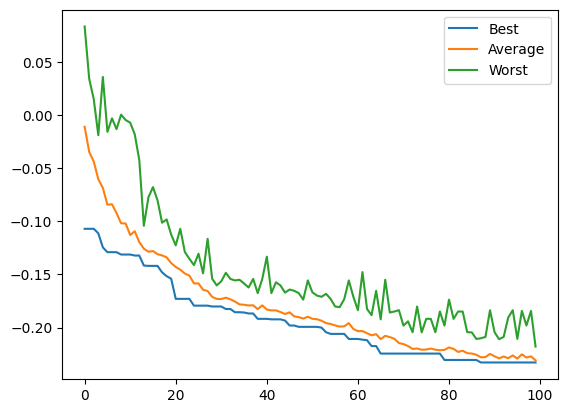

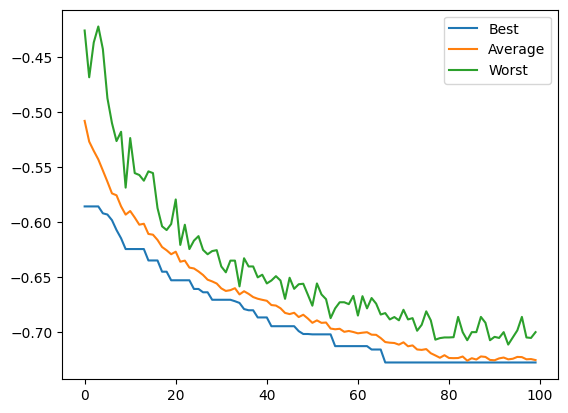

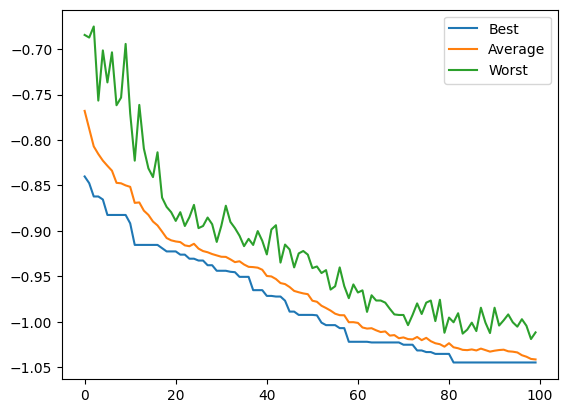

In [3]:
import utils
from CDChromosome import CD_Chromosome
from GA import GA

def communities_detection_with_ga(network, show=True, communities=2, noGen=10, fitness_fnc=None):
    if fitness_fnc is None:
        fitness_fnc = modularity
    
    gaParam = {'popSize' : network["noNodes"]//2, 'noGen' : noGen, 'graph' : network}
    problParam = {'min' : 0, 'max' : communities-1, 'function' : fitness_fnc, 'noDim' : network["noNodes"]}
    best_fitnesses = []
    worst_fitnesses = []
    avg_fitnesses = []
    generations = []

    ga = GA(CD_Chromosome, gaParam, problParam)
    ga.initialisation()
    ga.evaluation()
    
    global_best = ga.bestChromosome()

    for g in range(gaParam['noGen']):
        all_fitnesses = [c.fitness for c in ga.population]

        best_fitnesses.append(ga.bestChromosome().fitness)
        worst_fitnesses.append(ga.worstChromosome().fitness)
        avg_fitnesses.append(sum(all_fitnesses) / len(all_fitnesses))

        generations.append(g)
        
        ga.oneGenerationElitism2()
        
        best = ga.bestChromosome()
        if best.fitness > global_best.fitness:
            global_best = best
    
    if show:
        utils.plot_stats(generations, best_fitnesses, worst_fitnesses, avg_fitnesses)
    
    return global_best.repres

nt = utils.read_network('data/given/dolphins.gml')

communities_detection_with_ga(nt, True, 2, 100, modularity);
communities_detection_with_ga(nt, True, 2, 100, conductance);
communities_detection_with_ga(nt, True, 2, 100, normalized_cut);